In [1]:
import sys
sys.path.append("..")

In [2]:
csv_file_paths = [
    "../quotes/BILI_20250131.csv",
    "../quotes/TSLA_20250107.csv",
    "../quotes/TSLA_20250131.csv"
]

from fake_data import *
csv_data = load_csv_data(csv_file_paths[1])

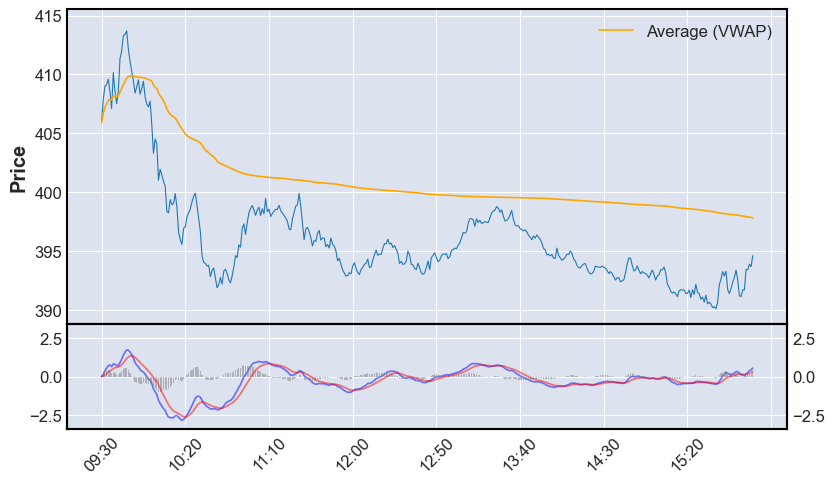

In [3]:
import pandas as pd
from plot import plot_trade_history

df = pd.DataFrame(csv_data)
df.set_index('date', inplace=True, drop=False)

plot_trade_history(df, [])

In [4]:
from Trend import Trend
current_index = 0
contract = 'TSLA'
while True:
    bars, current_index = fake_fetch_minute_data(contract, csv_data, current_index)
    if bars is None: break
    bars = pd.DataFrame(bars)
    trend = Trend(1)
    result = trend.cal(bars)

2025-01-07 10:39:00-05:00 max_rally 0.3449561027072403
2025-01-07 10:40:00-05:00 max_rally 0.3449561027072403
2025-01-07 10:41:00-05:00 max_rally 0.3449561027072403
2025-01-07 10:42:00-05:00 max_rally 0.3449561027072403
2025-01-07 10:43:00-05:00 max_rally 0.3449561027072403
2025-01-07 10:44:00-05:00 max_rally 0.3449561027072403
2025-01-07 10:45:00-05:00 max_rally 0.3449561027072403
2025-01-07 10:46:00-05:00 max_rally 0.3449561027072403
2025-01-07 10:47:00-05:00 max_rally 0.3449561027072403
2025-01-07 10:48:00-05:00 max_rally 0.3449561027072403
2025-01-07 10:49:00-05:00 max_rally 0.3449561027072403
2025-01-07 10:50:00-05:00 max_rally 0.3449561027072403
2025-01-07 10:51:00-05:00 max_rally 0.3449561027072403
2025-01-07 10:52:00-05:00 max_rally 0.3449561027072403
2025-01-07 10:53:00-05:00 max_rally 0.3449561027072403
2025-01-07 10:54:00-05:00 max_rally 0.3449561027072403
2025-01-07 10:55:00-05:00 max_rally 0.3449561027072403
2025-01-07 10:56:00-05:00 max_rally 0.3449561027072403
2025-01-07

In [5]:
bars